In [18]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
from scipy import stats
from scipy import optimize
from scipy.linalg import block_diag

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, List, Tuple

"""
Own packages
"""
from codelib.portfolio_optimization.risk_metrics import drawdown, maxdrawdown

from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix
from codelib.statistics.robust_covariance import marchencko_pastur_bounds, marchencko_pastur_density, fitting_error, crem_denoised_corr_mat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercises - Week 9


## Problem 1:  Portfolio characteristics 

In this exercise, we will compare a value weighted versus an equally weighted strategy on the sector level. 

__Question 1__

Obtain the Fama-French "12 industry portfolios" since 1999. Calculate a equally weighted return index and a value weighted return index. 

Plot the time series of the index development. 

__Question 2__

Plot a drawdown plot for the two indices. 

__Question 3__

Calculate the arihmetic and geometric return. 

__Question 4__

Calculate the ann. volatility. Also calculate the skewness and kurtosis. 

__Question 5__

Which strategy would you prefer?


### Solution 

__Question 1__

In [19]:
reader = FamaFrenchReader("12_Industry_Portfolios", start=datetime.datetime(1999, 1, 1))
industry_port = reader.read()

# print description
industry_port['DESCR']

'12 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202209 CRSP database. It contains value- and equal-weighted returns for 12 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2022 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (285 rows x 12 cols)\n  1 : Average Equal Weighted Returns -- Monthly (285 rows x 12 cols)\n  2 : Average Value Weighted Returns -- Annual (23 rows x 12 cols)\n  3 : Average Equal Weighted Returns -- Annual (23 rows x 12 cols)\n  4 : Number of Firms in Portfolios (285 rows x 12 cols)\n  5 : Average Firm Size (285 rows x 12 cols)\n  6 : Sum of BE / Sum of ME (24 rows x 12 cols)\n  7 : Value-Weighted Average of BE/ME (24 rows x 12 cols)'

In [20]:
# get equally weighted
ind_eq_weighted = industry_port[1] / 100
ind_eq_weighted.columns = ind_eq_weighted.columns.str.strip()
#ind_eq_weighted.index = pd.to_datetime(ind_eq_weighted.index, format="%Y-%m")

# get market cap weighted 
ind_mc_weighted = industry_port[0] / 100
ind_mc_weighted.columns = ind_mc_weighted.columns.str.strip()
#ind_mc_weighted.index = pd.to_datetime(ind_mc_weighted.index, format="%Y%m")

# get number of companies in each sector
num_companies = industry_port[4]
num_companies.columns = num_companies.columns.str.strip()
#num_companies.index = pd.to_datetime(num_companies.index, format="%Y%m")

# get average firm size 
avg_firm_size = industry_port[5]
avg_firm_size.columns = avg_firm_size.columns.str.strip()
#avg_firm_size.index = pd.to_datetime(avg_firm_size.index, format="%Y%m")

# get sector market cap 
sector_mkt_cap  = num_companies * avg_firm_size
total_mkt_cap = sector_mkt_cap.sum(axis=1)

# get relative market cap
sector_mkt_cap_relative = sector_mkt_cap.divide(total_mkt_cap, axis="rows")

# calculate market return 
market_return = (sector_mkt_cap_relative * ind_mc_weighted).sum(axis="columns")

# calculate equal weighted return 
equal_weighted_return = (ind_mc_weighted / 12.0).sum(axis="columns")

# asset list
asset_list = ind_mc_weighted.columns

In [21]:
mkt_index = (1 + market_return).cumprod()
eq_index = (1 + equal_weighted_return).cumprod()

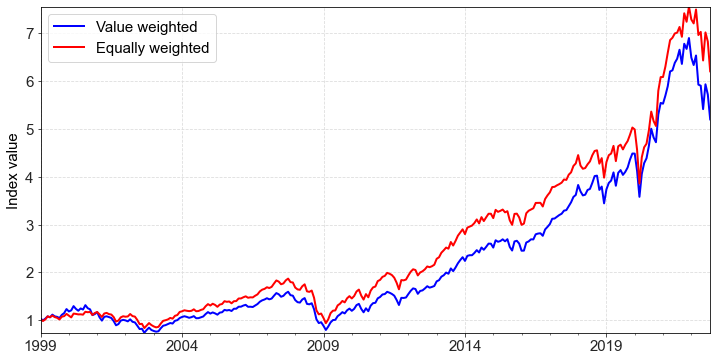

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))

mkt_index.plot(color="blue", label="Value weighted", xlabel="")
eq_index.plot(color="red", label="Equally weighted", xlabel="")
ax.set_ylabel("Index value")
ax.legend();

__Question 2__



In [23]:
dd_mkt = drawdown(mkt_index)[0]
dd_eq = drawdown(eq_index)[0]

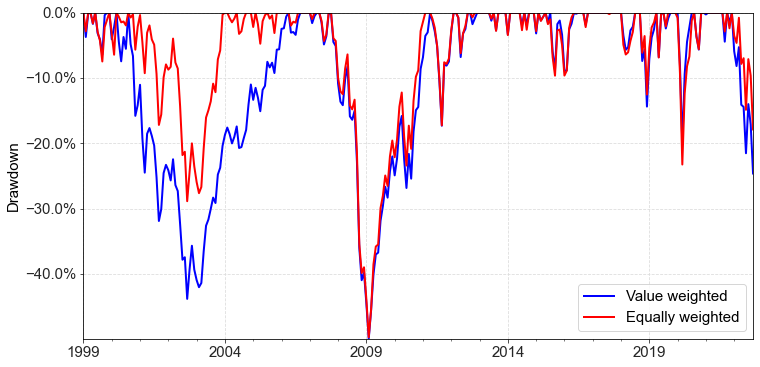

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))

dd_mkt.plot(color="blue", label="Value weighted", xlabel="")
dd_eq.plot(color="red", label="Equally weighted", xlabel="")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_ylabel("Drawdown")
ax.legend();

__Question 3 and 4__

In [25]:
portfolio_descriptive = pd.DataFrame(columns=['Value weighted', 'Equally weighted'])

portfolio_descriptive.loc['Arithmetic Avg. return (ann.)', 'Value weighted'] = np.average(market_return) * 12
portfolio_descriptive.loc['Arithmetic Avg. return (ann.)', 'Equally weighted'] = np.average(equal_weighted_return) * 12

portfolio_descriptive.loc['Geometric return (ann.)', 'Value weighted'] = mkt_index.values[-1]**(12 / len(mkt_index)) - 1
portfolio_descriptive.loc['Geometric return (ann.)', 'Equally weighted'] = eq_index.values[-1]**(12 / len(eq_index)) - 1

portfolio_descriptive.loc['Volatility (ann.)', 'Value weighted'] = market_return.std() * np.sqrt(12)
portfolio_descriptive.loc['Volatility (ann.)', 'Equally weighted'] = equal_weighted_return.std() * np.sqrt(12)

portfolio_descriptive.loc['Kurtosis', 'Value weighted'] = market_return.kurt()
portfolio_descriptive.loc['Kurtosis', 'Equally weighted'] = equal_weighted_return.kurt()

portfolio_descriptive.loc['Skewness', 'Value weighted'] = market_return.skew()
portfolio_descriptive.loc['Skewness', 'Equally weighted'] = equal_weighted_return.skew()


In [26]:
portfolio_descriptive

,Value weighted,Equally weighted
Arithmetic Avg. return (ann.),0.082021,0.088675
Geometric return (ann.),0.07185,0.07985
Volatility (ann.),0.157084,0.151874
Kurtosis,0.801867,1.794168
Skewness,-0.494829,-0.457462


__Quesition 5__

?

## Problem 2:  Long-term risk and portfolio optimization 

Again, consider the Fama-French "12 industry portfolios" since 1999.

__Question 1__

We may assume that log-returns follows a multivariate normal distribution. 

$$
\log \mathbf{P}_{t+1} - \log \mathbf{P}_t \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

Estimate the expected log-return and the covariance matrix of log-returns. 

__Question 2__

Based on the above estimates, simulate the asset prices 5-years into the future. Consider 10,000 paths and yearly time steps. 

Calculate the return of an equally weighted constant mix portfolio. Plot a fanchart of the development of the index value of the constant mix. Compare with a buy and hold portfolio. 

__Question 3__

Calculate the mean, variance and CVaR at the 5-year horizon. 

__Question 4__

Select the constant mix portfolio that minimizes the 5Y CVaR(5%) for a return target of e.g. $50\%$.  

__Question 5__

Suggest and apply a resampling approach. 

__Question 6__

Do we obtain similar results with a buy and hold strategy?

### Solution 

__Question 1__

As previously seen, we can simply use `pandas-datareader`. 

In [27]:
reader = FamaFrenchReader("12_Industry_Portfolios", start=datetime.datetime(1999, 1, 1))
industry_port = reader.read()

# print description
industry_port['DESCR']

'12 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202209 CRSP database. It contains value- and equal-weighted returns for 12 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2022 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (285 rows x 12 cols)\n  1 : Average Equal Weighted Returns -- Monthly (285 rows x 12 cols)\n  2 : Average Value Weighted Returns -- Annual (23 rows x 12 cols)\n  3 : Average Equal Weighted Returns -- Annual (23 rows x 12 cols)\n  4 : Number of Firms in Portfolios (285 rows x 12 cols)\n  5 : Average Firm Size (285 rows x 12 cols)\n  6 : Sum of BE / Sum of ME (24 rows x 12 cols)\n  7 : Value-Weighted Average of BE/ME (24 rows x 12 cols)'

In [28]:
# get equally weighted
ind_eq_weighted = industry_port[1] / 100
ind_eq_weighted.columns = ind_eq_weighted.columns.str.strip()


# get market cap weighted 
ind_mc_weighted = industry_port[0] / 100
ind_mc_weighted.columns = ind_mc_weighted.columns.str.strip()

asset_list = ind_mc_weighted.columns

In [29]:
"""
Calculate log returns
"""

log_returns = np.log(1+ind_mc_weighted)

In [30]:
mean_log_returns = log_returns.mean()
mean_log_returns

NoDur    0.006391
Durbl    0.005990
Manuf    0.007208
Enrgy    0.006727
Chems    0.006060
BusEq    0.006156
Telcm    0.001919
Utils    0.006500
Shops    0.006958
Hlth     0.006184
Money    0.004854
Other    0.004258
dtype: float64

In [31]:
cov_mat_log_returns = log_returns.cov()
cov_mat_log_returns

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
NoDur,0.001347,0.001704,0.001464,0.001346,0.001229,0.001099,0.001194,0.000959,0.001112,0.000921,0.001474,0.001315
Durbl,0.001704,0.007121,0.003921,0.002988,0.002418,0.003804,0.002654,0.001374,0.002898,0.001725,0.003581,0.003522
Manuf,0.001464,0.003921,0.003398,0.002749,0.002070,0.002989,0.002195,0.001237,0.002105,0.001389,0.002750,0.002806
Enrgy,0.001346,0.002988,0.002749,0.005171,0.001744,0.001919,0.001789,0.001560,0.001429,0.001093,0.002391,0.002223
Chems,0.001229,0.002418,0.002070,0.001744,0.001866,0.001604,0.001376,0.000979,0.001365,0.001094,0.001837,0.001797
BusEq,0.001099,0.003804,0.002989,0.001919,0.001604,0.005081,0.002680,0.000759,0.002285,0.001436,0.002348,0.002768
Telcm,0.001194,0.002654,0.002195,0.001789,0.001376,0.002680,0.002849,0.000880,0.001678,0.001178,0.002043,0.002084
Utils,0.000959,0.001374,0.001237,0.001560,0.000979,0.000759,0.000880,0.001883,0.000761,0.000771,0.001105,0.001086
Shops,0.001112,0.002898,0.002105,0.001429,0.001365,0.002285,0.001678,0.000761,0.002134,0.001081,0.001969,0.001965
Hlth,0.000921,0.001725,0.001389,0.001093,0.001094,0.001436,0.001178,0.000771,0.001081,0.001711,0.001438,0.001323


In [32]:
corr_mat_log_returns = cov_to_corr_matrix(cov_mat_log_returns)

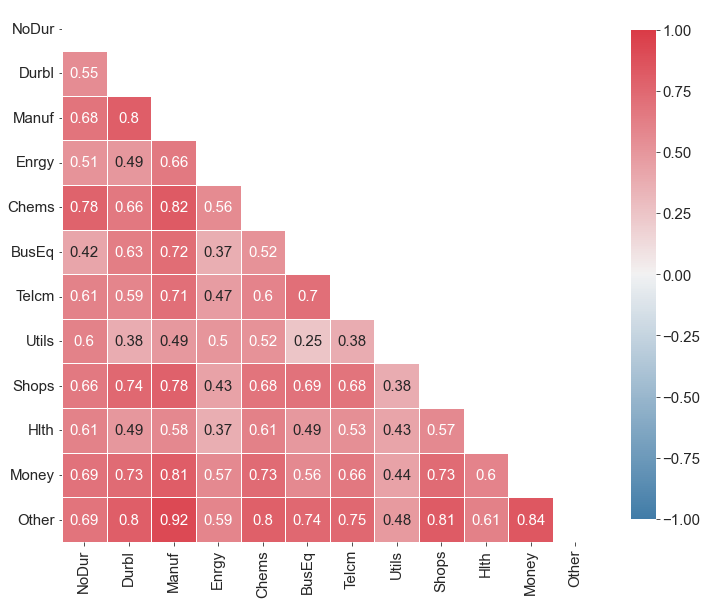

In [33]:
fig, ax = plt.subplots(figsize=(12, 12))
correlation_plot(corr_mat_log_returns, names=asset_list, include_values=True, ax=ax)

__Question 2__

We can simulate log-returns using a multivariate normal distribution and aggregate across time. 

In [34]:
def simulate_asset_prices(mu: np.ndarray, cov_mat: np.ndarray,
                          horizon: float, dt: float, num_sim: int,
                          transform_input: bool=False) -> np.ndarray:
    
    """
    Simulates asset prices
    
    Parameters
    ----------
    mu: 
        Expected log-returns. 
    cov_mat: 
        Covariance matrix of log-returns. 
    horizon: 
        Simulation horizon in years. 
    dt: 
        Time step. 
    num_sim: 
        Number of simulations. 
    transform_input: 
        Boolean indicating whether to transform mu and cov_mat to time_step. 
    
    
    Returns
    -------
    np.ndarray
        Simulated asset prices  [num sim x num time steps x num_assets]. 
    
    
    """
    
    if transform_input:
        mu = mu * dt
        cov_mat = cov_mat * dt
        
    num_assets = len(mu)
    
    num_periods = int(horizon / dt)
    
    # allocate memory
    asset_prices = np.ones((num_sim, 1 + num_periods, num_assets))
    
    # simulate returns
    log_ret = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_periods))
    
    # transform returns to asset prices
    asset_prices[:, 1:, :] = np.exp(np.cumsum(log_ret, axis=1))
    
    return asset_prices

In [35]:
"""
Simulate asset prices
"""

num_sim = 5000
dt = 1.0 # 1.0/12.0
horizon = 5.0
mu = mean_log_returns.values * 12.0
cov_mat = cov_mat_log_returns * 12.0

time_points = np.arange(0.0, horizon + 0.01, dt)
asset_prices  = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)

The value of a buy and hold strategy is simply given by (assuming the initial value of the assets and portfolios are equal to 1)

$$
V_T = \mathbf{w}^\top \mathbf{P}_T
$$

where $V_T$ denotes the portfolio value, $\mathbf{P}_T$ denotes the vector of asset prices and $\mathbf{w}$ denote the initial portfolio weights. 

In [36]:
"""
Buy and hold strategy 
"""

port_w = np.ones(len(mu)) / len(mu)

buy_and_hold_index = asset_prices @ port_w

In [55]:
asset_prices.shape

(5000, 6, 12)

In [56]:
buy_and_hold_index.shape

(5000, 6)

The value of the constant mix strategy 

$$
V_T = \prod_{t = 1}^T (1 + \mathbf{w}^\top \mathbf{R}_t)
$$

where $\mathbf{R}_t$ is the period return of the assets. 

In [37]:
"""
Constant mix porfolio (monthly rebalancing)
"""

def calculate_period_returns(index: np.ndarray) -> np.ndarray:
    
    """
    Calculates period returns
    
    Paramters
    ---------
    index: 
        Index values [num sim x num time steps x num_assets]. 
        
    Returns
    -------
    np.ndarray
        Period returns. 
    
    """
    
    # get size of matrix
    n = index.shape[1]

    # get matrix not lagged
    new_mat = index[:, 1:n]
    # get matrix lagged
    old_mat = index[:, 0:n-1]
    # get 1 + return
    periodtr = new_mat / old_mat
    
    return periodtr - 1
    

def calculate_constant_mix_index(index: np.ndarray, weights: np.ndarray) -> np.ndarray:
    
    """
    Calculates cum. return index of a constant mix strategy. 
    
    Parameters
    ----------
    index: 
        Index values  [num sim x num time steps x num_assets]. 
    weights: 
        Portfolio weights. 
        
    
    Returns
    -------
    np.ndarray
        Cum. return index [num sim x num time steps]. 
    
    """
    
    port_index = np.ones((index.shape[0], index.shape[1]))
    
    # calculate period returns on assets
    per_ret = calculate_period_returns(index)
    
    # calculate port. period return
    port_per_ret = per_ret @ weights
    
    # calculate port. index
    port_index[:, 1:] = np.cumprod(1 + port_per_ret, axis=1)
    
    return port_index
    

constant_mix_index = calculate_constant_mix_index(asset_prices, port_w)

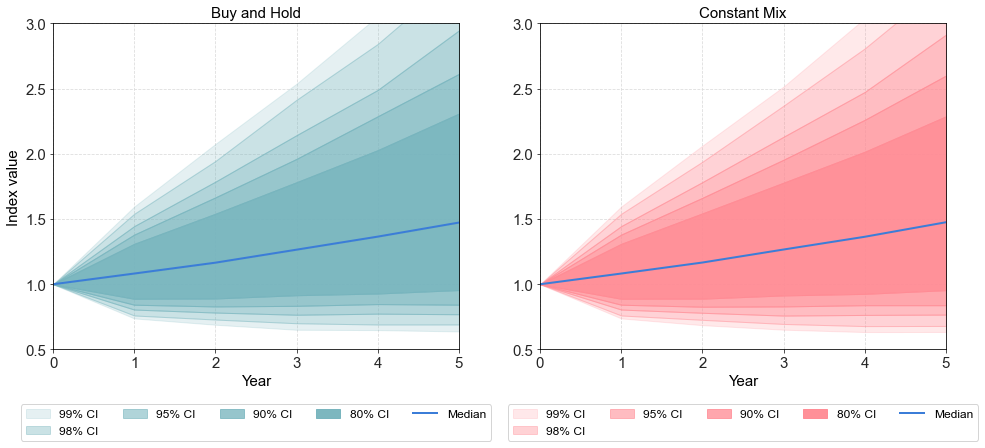

In [38]:
# calculate percentiles
percentiles_buy_and_hold = np.percentile(buy_and_hold_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)
percentiles_constant_mix = np.percentile(constant_mix_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fan_chart(time_points,
          percentiles_buy_and_hold,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[0])

ax[0].set_xlabel("Year", size=15)
ax[0].set_ylabel("Index value", size=15)
ax[0].set_title("Buy and Hold", size=15)
ax[0].set_ylim([0.5, 3.0])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

fan_chart(time_points,
          percentiles_constant_mix,
          color=default_colors['red'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[1])

ax[1].set_xlabel("Year", size=15)
ax[1].set_title("Constant Mix", size=15)
ax[1].set_ylim([0.5, 3.0])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

__Question 3__

In [39]:
np.std(buy_and_hold_index[:, -1])

0.562129511508754

In [40]:
np.std(constant_mix_index[:, -1])

0.5507563992139779

In [41]:
np.mean(buy_and_hold_index[:, -1])

1.5700454772876677

In [42]:
np.mean(constant_mix_index[:, -1])

1.5640409102442163

In [58]:
buy_and_hold_index[:, -1]

array([0.81894722, 1.3276837 , 1.88902753, ..., 1.15955731, 1.12611071,
       1.47472399])

In [60]:
value_at_risk = np.percentile(buy_and_hold_index[:, -1], 5)
cond_value_at_risk = np.mean(buy_and_hold_index[:, -1][buy_and_hold_index[:, -1] <= value_at_risk])
cond_value_at_risk

0.7491346929703432

In [61]:
value_at_risk = np.percentile(constant_mix_index[:, -1], 5)
cond_value_at_risk = np.mean(constant_mix_index[:, -1][constant_mix_index[:, -1] <= value_at_risk])
cond_value_at_risk

0.7408919857975103

In [45]:
np.mean(calculate_constant_mix_index(asset_prices, port_w)[:, -1])

1.5640409102442163

__Question 4__

We can apply the techniques from the exercises in week 5. 


[Rockafeller and Uryasev (2000)](https://www.ise.ufl.edu/uryasev/files/2011/11/CVaR1_JOR.pdf) suggest an alternative way of solving the problem that ensures that the objective function is convex.  

Basically, the idea is that solving the minimization problem (when using the empirical distribution function)

$$
\underset{\mathbf{w}, \alpha}{\text{arg min }}  \alpha + \frac{1}{N (1 - \beta)} \sum_{i=1}^N \max [0, -\mathbf{w}^\top \mathbf{R}_i- \alpha]
$$

will result in the portfolio with lowest $\text{CVaR}_\beta[R_p]$ given the used constraints. $\alpha$ can be interpreted as the corresponding portfolio $\text{VaR}_\beta[R_p]$. 

We need to take into account the difference between how the cum. return index of the buy and hold and constant mix portfolio is calculated. 

In [46]:
def objective_function(x, index, beta):

    w = x[0:-1]
    alpha = x[-1]

    constant_mix_index = calculate_constant_mix_index(index, w)[:, -1]

    # tail_scenarios
    tail_scenarios = np.maximum(-constant_mix_index - alpha, 0.0)

    obj_func = alpha + np.sum(tail_scenarios) / (len(constant_mix_index)*(1-beta))

    return obj_func

# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x[:-1]) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x[:-1]}

# alternatively use 
bounds = [(0.0, 1.0)] * 12 + [(None, None)]


def target_return_constraint(x, target, asset_prices):

    return np.mean(calculate_constant_mix_index(asset_prices, x[:-1])[:, -1]) - target

port_weights = list()
targets = [1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7]
for target in targets:
    
    print(target)
    
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: target_return_constraint(x, target, asset_prices)}


    x0 = np.r_[np.ones(12) / 12.0, 0.3]
    res = optimize.minimize(objective_function, x0=x0, args=(asset_prices, 0.95),
                            method='SLSQP',
                            constraints=[sum_to_one_cons,  target_cons], 
                            options={'ftol': 1e-9, 'disp': True}, bounds=bounds)

    port_weights.append(res.x[:-1])
    
    
port_weights = np.array(port_weights)

1.4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7421088165136225
            Iterations: 23
            Function evaluations: 341
            Gradient evaluations: 23
1.45
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.798996573256572
            Iterations: 18
            Function evaluations: 274
            Gradient evaluations: 18
1.5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.845989396200082
            Iterations: 25
            Function evaluations: 386
            Gradient evaluations: 25
1.55
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.8826090827716427
            Iterations: 28
            Function evaluations: 419
            Gradient evaluations: 28
1.6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.8688361389323875
            Iterations

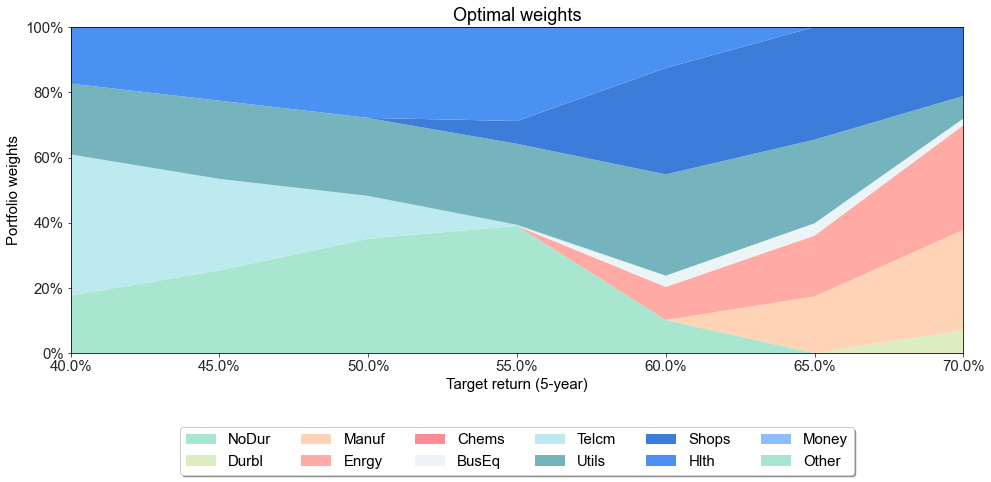

In [47]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(np.array(targets) - 1.0, port_weights.T, labels=asset_list);
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=6);
ax.set_xlabel("Target return (5-year)")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights");

In [48]:
for i in range(len(targets)):
    
    index_vals = calculate_constant_mix_index(asset_prices, port_weights[i])[:, -1]
    value_at_risk = np.percentile(index_vals, 5)
    cond_value_at_risk = np.mean(index_vals[index_vals <= value_at_risk])
    print("CVaR(5%) for target = {}: ".format(targets[i]))
    print(cond_value_at_risk)
    print("\n")

CVaR(5%) for target = 1.4: 
0.7421088165136224


CVaR(5%) for target = 1.45: 
0.798996596664658


CVaR(5%) for target = 1.5: 
0.845989396200082


CVaR(5%) for target = 1.55: 
0.8826090827716426


CVaR(5%) for target = 1.6: 
0.8688361389323875


CVaR(5%) for target = 1.65: 
0.8039767344562547


CVaR(5%) for target = 1.7: 
0.7060775478642642




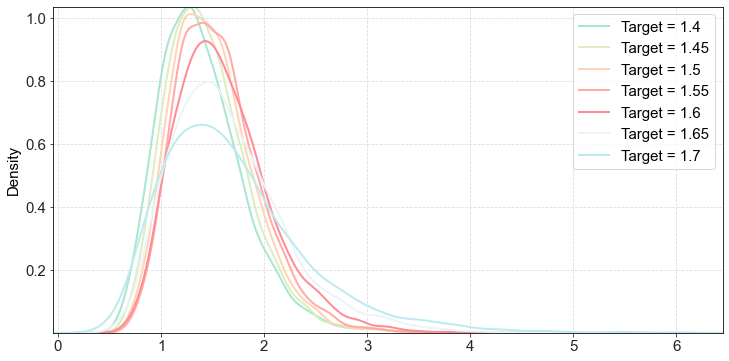

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))    

for i in range(len(targets)):
    sns.kdeplot(calculate_constant_mix_index(asset_prices, port_weights[i])[:, -1],
                label="Target = {}".format(targets[i]))
    
ax.legend();

__Question 5__

We simply resample a number of paths from the simulated asset prices and perform the portfolio optimization again. Repeat this a large number of times. The average is the optimal allocations. 

In [50]:
targets = [1.4, 1.45, 1.5, 1.55, 1.6, 1.65]

num_resamples = 50
size_resample = 500
optimal_port_resampled_weights = np.zeros((len(targets), 12))
for i in range(num_resamples): 
    print(i)
    asset_prices_sim = asset_prices[np.random.randint(0, num_sim, size=size_resample), :, :]
    
    opt_port_w_sim = []
    for target in targets:

        #print(target)

        # define constraint 
        target_cons = {'type': 'eq',
                       'fun' : lambda x: target_return_constraint(x, target, asset_prices_sim)}


        x0 = np.r_[np.ones(12) / 12.0, 0.3]
        res = optimize.minimize(objective_function, x0=x0, args=(asset_prices_sim, 0.95),
                                method='SLSQP',
                                constraints=[sum_to_one_cons,  target_cons], 
                                options={'ftol': 1e-9, 'disp': False}, bounds=bounds)

        opt_port_w_sim.append(res.x[:-1])


    optimal_port_resampled_weights += np.array(opt_port_w_sim) / num_resamples
    
optimal_port_resampled_weights = np.array(optimal_port_resampled_weights)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


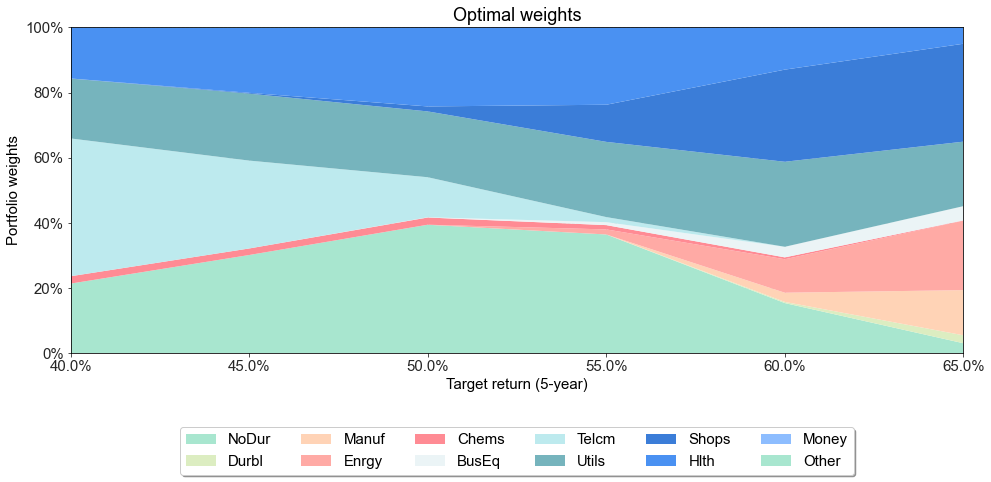

In [51]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(np.array(targets) - 1.0, optimal_port_resampled_weights.T, labels=asset_list);
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=6);
ax.set_xlabel("Target return (5-year)")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights");

In [52]:
for i in range(len(targets)):
    
    index_vals = calculate_constant_mix_index(asset_prices, optimal_port_resampled_weights[i])[:, -1]
    value_at_risk = np.percentile(index_vals, 5)
    cond_value_at_risk = np.mean(index_vals[index_vals <= value_at_risk])
    print("CVaR(5%) for target = {}: ".format(targets[i]))
    print(cond_value_at_risk)
    print("\n")

CVaR(5%) for target = 1.4: 
0.743823954670174


CVaR(5%) for target = 1.45: 
0.800966808304064


CVaR(5%) for target = 1.5: 
0.8479122505570464


CVaR(5%) for target = 1.55: 
0.8809238747009137


CVaR(5%) for target = 1.6: 
0.866045560152487


CVaR(5%) for target = 1.65: 
0.8003409944469704




__Question 6__

In [53]:
def objective_function_buy_and_hold(x, index, beta):

    w = x[0:-1]
    alpha = x[-1]

    buy_and_hold_index = (index @ w)[:, -1]

    # tail_scenarios
    tail_scenarios = np.maximum(-buy_and_hold_index - alpha, 0.0)

    obj_func = alpha + np.sum(tail_scenarios) / (len(buy_and_hold_index)*(1-beta))

    return obj_func

port_weights = list()
targets = [1.4, 1.45, 1.5, 1.55, 1.6, 1.65]

num_resamples = 50
size_resample = 500
optimal_port_resampled_weights_buy_and_hold = np.zeros((len(targets), 12))
for i in range(num_resamples): 
    print(i)
    asset_prices_sim = asset_prices[np.random.randint(0, num_sim, size=size_resample), :, :]
    
    opt_port_w_sim = []
    for target in targets:

        #print(target)

        # define constraint 
        target_cons = {'type': 'eq',
                       'fun' : lambda x: np.mean((asset_prices_sim @ x[:-1])[:, -1]) - target}


        x0 = np.r_[np.ones(12) / 12.0, 0.3]
        res = optimize.minimize(objective_function_buy_and_hold, x0=x0, args=(asset_prices_sim, 0.95),
                                method='SLSQP',
                                constraints=[sum_to_one_cons,  target_cons], 
                                options={'ftol': 1e-9, 'disp': False}, bounds=bounds)

        opt_port_w_sim.append(res.x[:-1])


    optimal_port_resampled_weights_buy_and_hold += np.array(opt_port_w_sim) / num_resamples
    
optimal_port_resampled_weights_buy_and_hold = np.array(optimal_port_resampled_weights_buy_and_hold)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


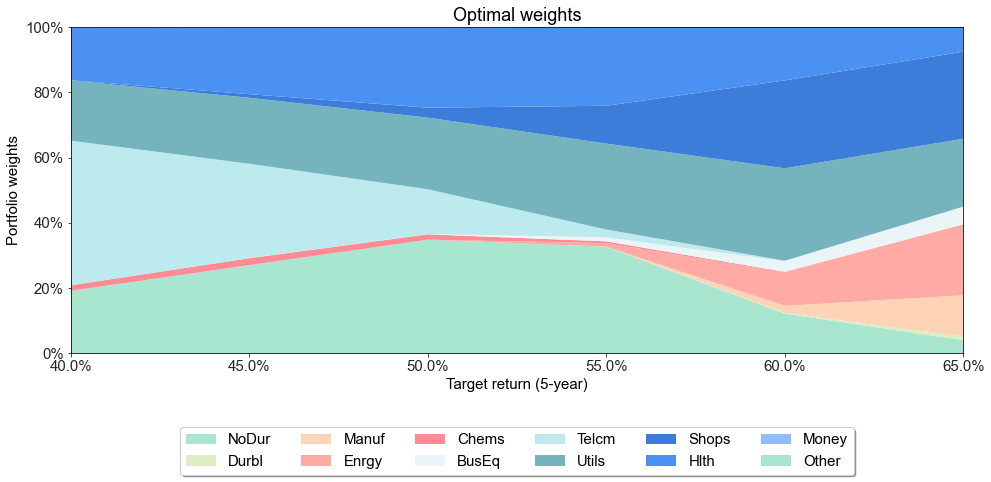

In [54]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(np.array(targets) - 1.0, optimal_port_resampled_weights_buy_and_hold.T, labels=asset_list);
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=6);
ax.set_xlabel("Target return (5-year)")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights");